In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
from keras.utils import multi_gpu_model
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
TRAIN_PATH = '/home/apil/data/hw_forms/train/'
TEST_PATH =  '/home/apil/data/hw_forms/test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
import glob
import cv2

Using TensorFlow backend.


In [2]:
train_ids = glob.glob(TRAIN_PATH+"/images/*.jpg")
test_ids =  glob.glob(TEST_PATH+"/images/*.jpg")

In [3]:
def parseName(path):
    return path[path.rfind('/')+1:]

In [4]:
x_train_file = "X_train_many_256x256.dat.npy"
y_train_file = "Y_train__many_256x256.dat.npy"

if (os.path.exists(x_train_file)):
    X_train = np.load(x_train_file)
    Y_train = np.load(y_train_file)
else:
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.bool)

    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    for n, path in tqdm(enumerate(train_ids), total=len(train_ids)):
        id_ = parseName(path)
        img = imread(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = np.expand_dims(img, axis=-1)

        mask_path = TRAIN_PATH + "masks/"+id_
        mask = imread(mask_path)
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) 
        Y_train[n] = np.expand_dims(mask, axis=-1)
    
    np.save(x_train_file,X_train)
    np.save(y_train_file,Y_train)

In [5]:
x_test_file = "X_test_many_256x256.dat.npy"

if os.path.exists(x_test_file):
    X_test = np.load(x_test_file)
else:
    # Get and resize test images
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

    sizes_test = []
    print('Getting and resizing test images ... ')
    sys.stdout.flush()
    for n, path in tqdm(enumerate(test_ids), total=len(test_ids)):
        img = imread(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = np.expand_dims(img, axis=-1)
    np.save(x_test_file, X_test)
    print('Done!')

In [6]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [7]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c5)

u6 = concatenate([u6, c4])

c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [8]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

In [ ]:
# Fit model
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model_many_256x256.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 918 samples, validate on 102 samples
Epoch 1/50
192/918 [=====>........................] - ETA: 4:13 - loss: 0.0648 - mean_iou: 0.4157

In [9]:
# Predict on train, val and test
model = load_model('model_many_256x256.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
threshold_pred = 0.8
preds_train_t = (preds_train > threshold_pred).astype(np.uint8)
preds_val_t = (preds_val > threshold_pred).astype(np.uint8)
preds_test_t = (preds_test > threshold_pred).astype(np.uint8)

# Create list of upsampled test masks
# preds_test_upsampled = []
# for i in range(len(preds_test)):
#     preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
#                                        (sizes_test[i][0], sizes_test[i][1]), 
#                                        mode='constant', preserve_range=True))

49/49 [==============================] - 1s 14ms/step


In [10]:
# Perform a sanity check on some random training samples
def plotOneTrainImage():
    ix = random.randint(0, len(preds_train_t))
    fig = plt.figure(figsize=(15,30))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(np.squeeze(X_train[ix]))
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(np.squeeze(Y_train[ix]))
    ax3 = fig.add_subplot(1,3,3)
    ax3.imshow(np.squeeze(preds_train_t[ix]))

    plt.show()

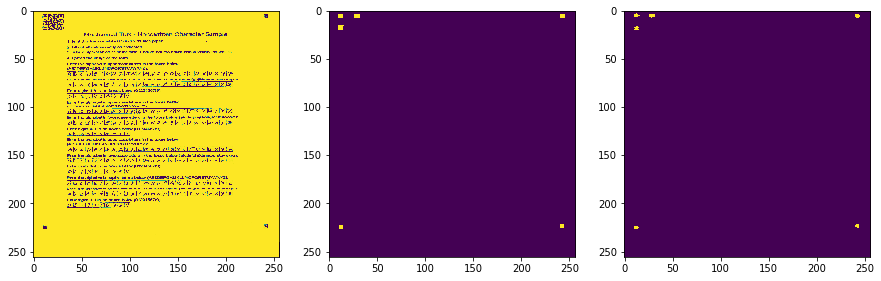

In [11]:
plotOneTrainImage()

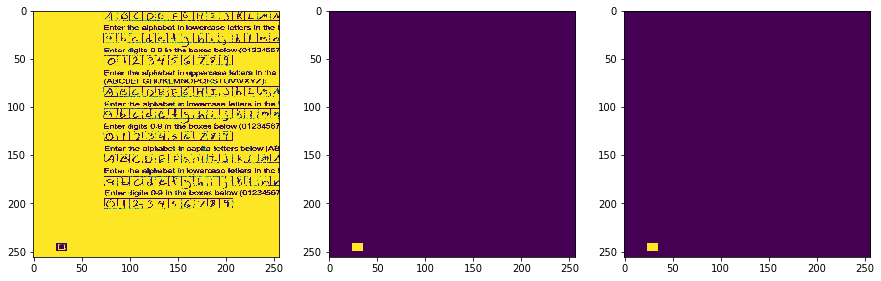

In [12]:
plotOneTrainImage()

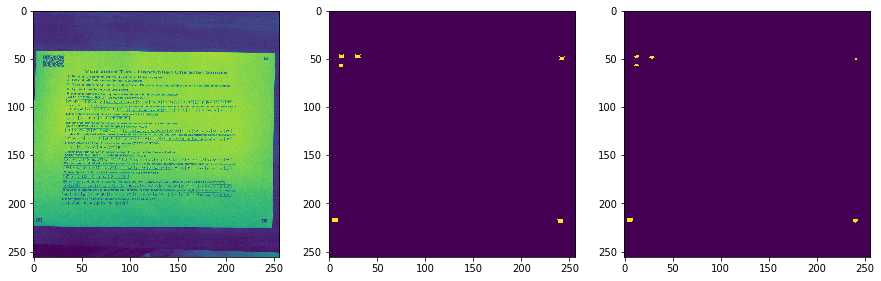

In [13]:
plotOneTrainImage()

In [15]:
def plotOneValidImage():
    ix = random.randint(0, len(preds_val_t))
    print("showing validation image {:d} of {:d}".format(ix,len(preds_val_t)))
    fig = plt.figure(figsize=(15,30))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(np.squeeze(X_train[int(X_train.shape[0]*0.9):][ix]))
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
    ax3 = fig.add_subplot(1,3,3)
    ax3.imshow(np.squeeze(preds_val_t[ix]))

    plt.show()    

showing validation image 63 of 102


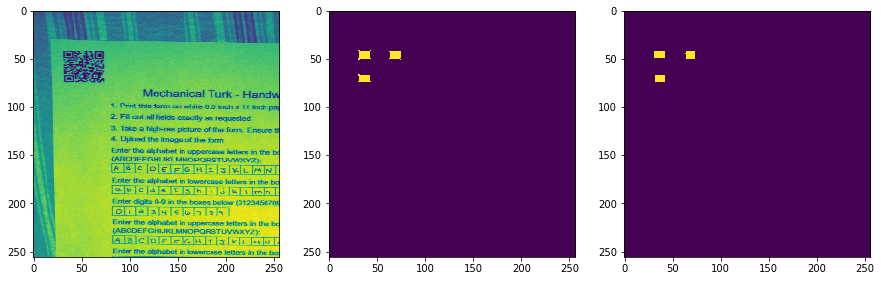

In [16]:
plotOneValidImage()

showing validation image 7 of 102


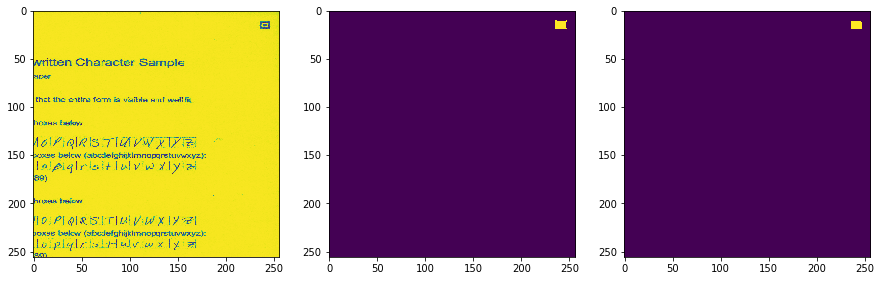

In [17]:
plotOneValidImage()

showing validation image 41 of 102


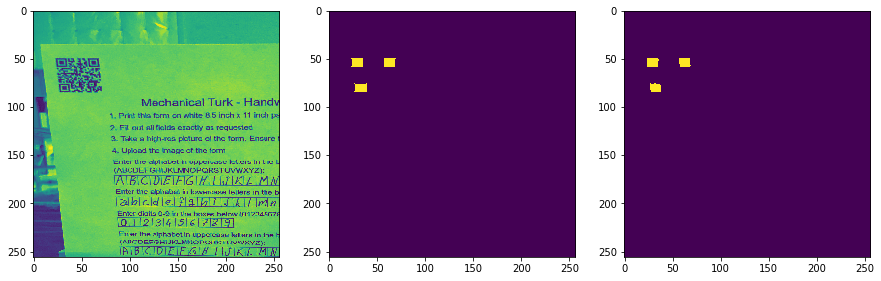

In [18]:
plotOneValidImage()

showing validation image 88 of 102


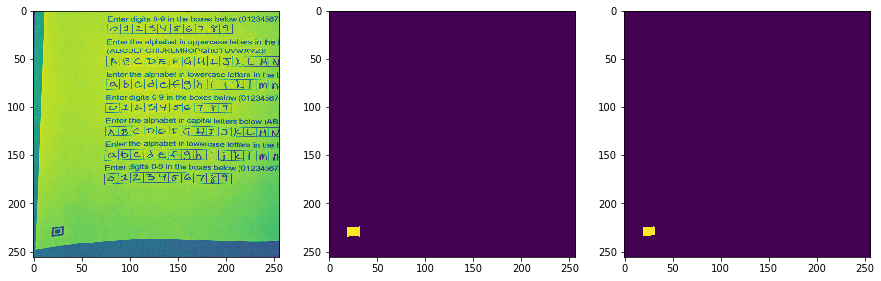

In [19]:
plotOneValidImage()

showing validation image 15 of 102


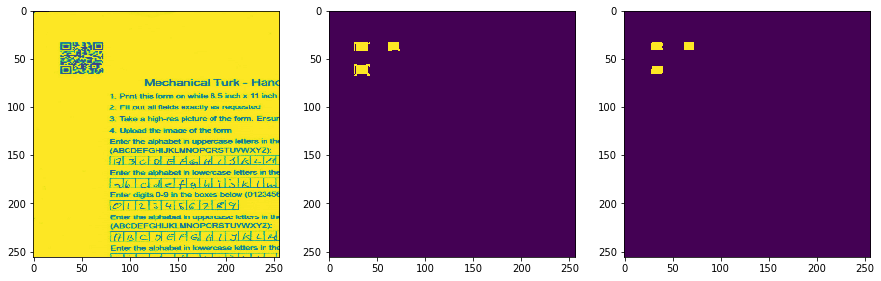

In [20]:
plotOneValidImage()

showing validation image 47 of 102


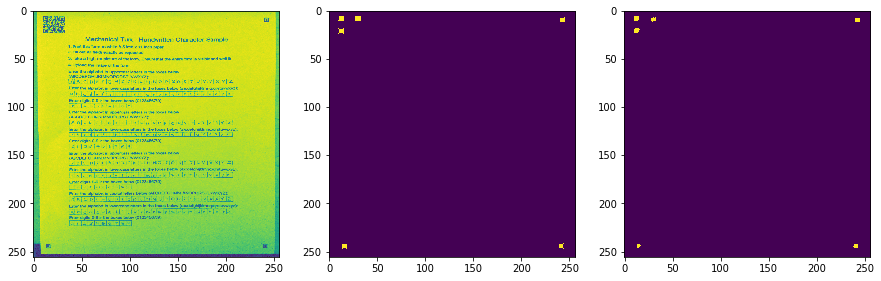

In [21]:
plotOneValidImage()

showing validation image 19 of 102


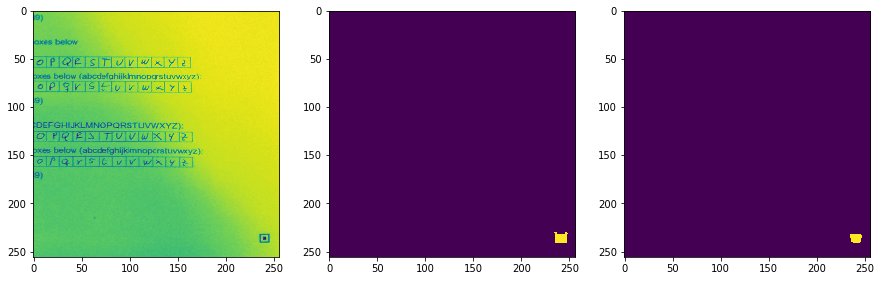

In [22]:
plotOneValidImage()

showing validation image 28 of 102


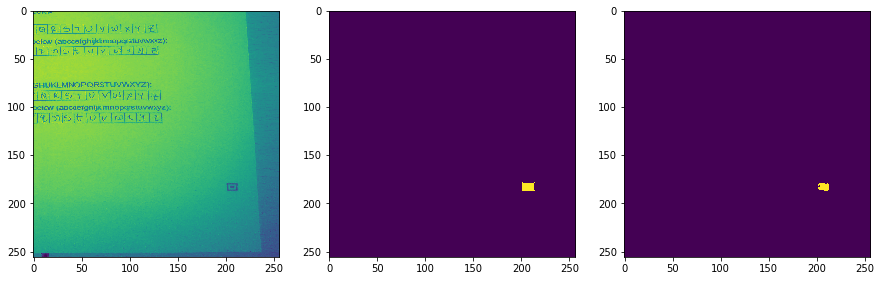

In [23]:
plotOneValidImage()

showing validation image 60 of 102


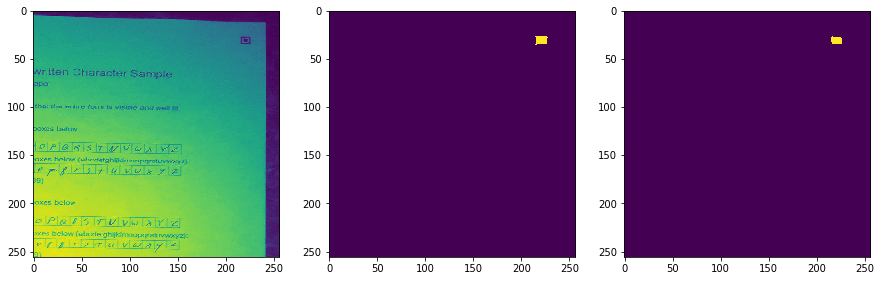

In [24]:
plotOneValidImage()

showing validation image 80 of 102


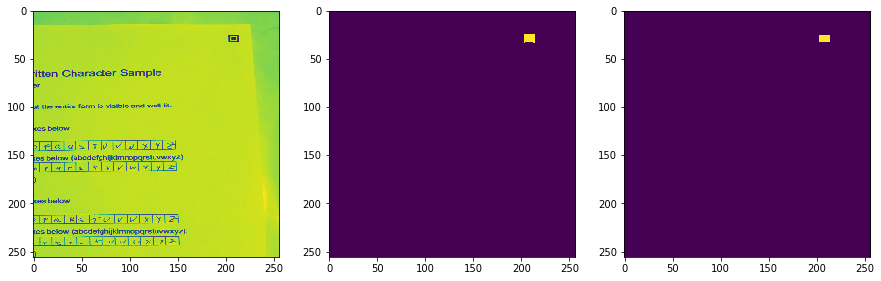

In [25]:
plotOneValidImage()

showing validation image 60 of 102


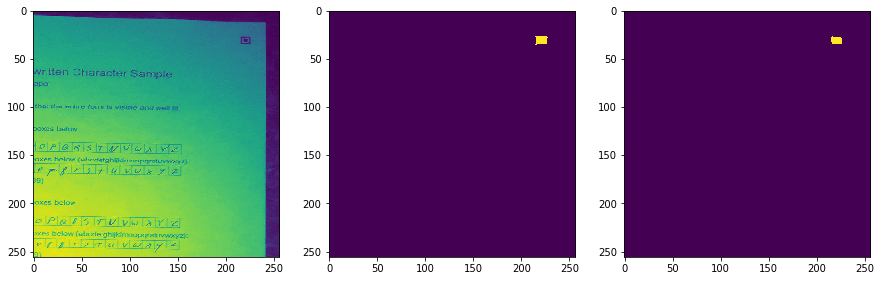

In [26]:
plotOneValidImage()

showing validation image 37 of 102


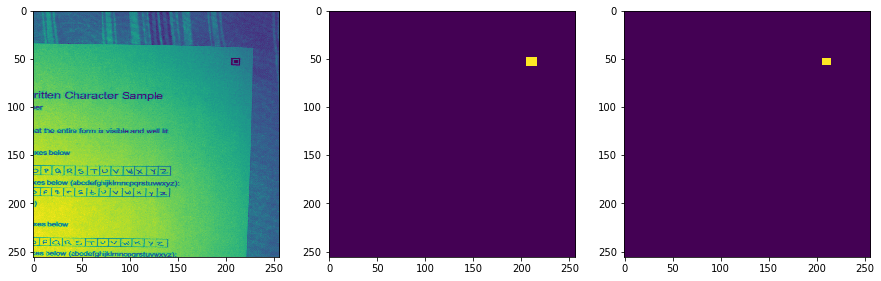

In [27]:
plotOneValidImage()

showing validation image 21 of 102


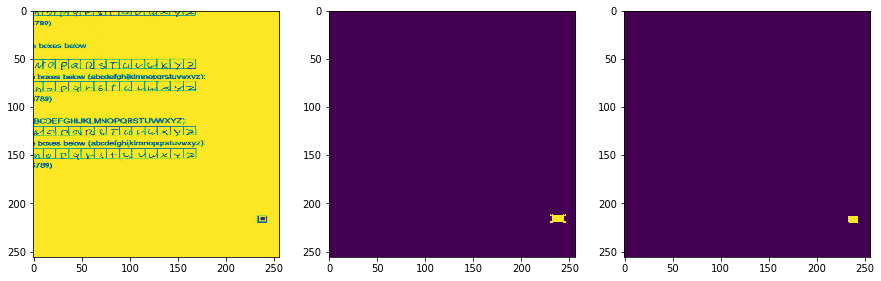

In [28]:
plotOneValidImage()

showing validation image 87 of 102


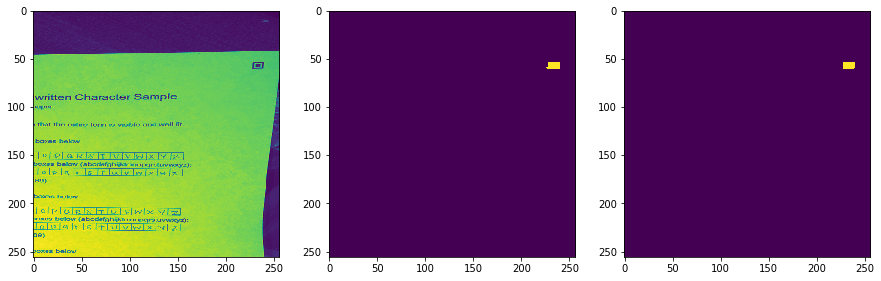

In [29]:
plotOneValidImage()

showing validation image 84 of 102


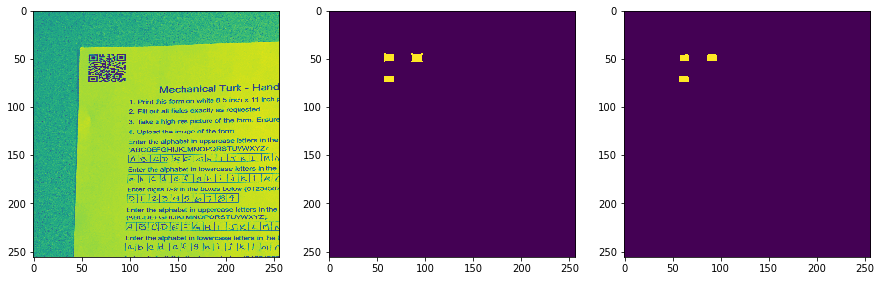

In [30]:
plotOneValidImage()

showing validation image 53 of 102


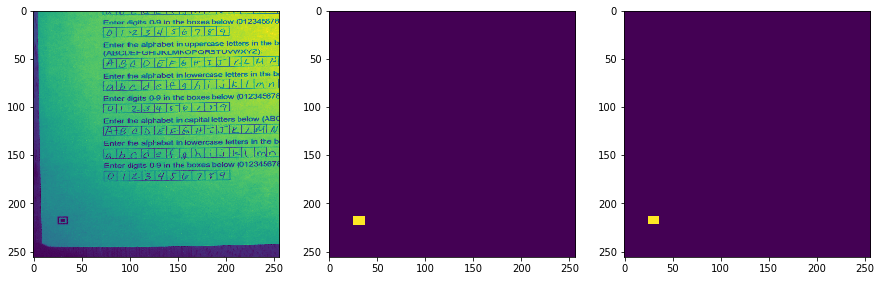

In [31]:
plotOneValidImage()